# Example for DSAFT model (based on CoxPH from PyCox)

In this notebook we will show how to train and get computed evaluation metric from model, based on [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf) provided by [PyCox](https://github.com/havakv/pycox) package.
We will use the METABRIC data sets as an example

※ Evaluation metric depends on [Lifelines](https://lifelines.readthedocs.io/en/latest/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import Tensor
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [5]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [6]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [8]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [9]:
x_train.shape

(1218, 9)

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [10]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

#### DSAFT Loss

Loss functions for Deep Semi-parametric AFT (DSAFT) models are different from that of CoxPH. However, application is simple that only change of loss function is needed after instantiating PyCox model.

In [11]:
# set DSAFT Loss
# (Rank-type loss in this example)

## DSAFT - rank loss function
def dsaft_rank_loss(theta, durations, events):
    '''
    theta: prediction output from DNN layers
    durations: log-scaled observed time (log(Y))
    events: right-censoring-indicator (delta)
    '''
    # compute residual e_i
    e_vector = theta.sub(durations.view(-1,1).add(1e-32).log()).neg()
    
    # evaluate loss function based on formula,
    # mul(1 / e_vector.shape[0] ** 2) : scaling constant
    return e_vector.sub(e_vector.view(-1)).mul(e_vector.sub(e_vector.view(-1))<=0).abs().mul(events.view(-1,1)).sum().mul(1 / e_vector.shape[0] ** 2)

class DSAFTRankLoss(torch.nn.Module):
    def forward(self, log_h: Tensor, durations: Tensor, events: Tensor) -> Tensor:
        return dsaft_rank_loss(log_h, durations, events)

In [12]:
model = CoxPH(net, tt.optim.Adam)

In [13]:
model.loss = DSAFTRankLoss()

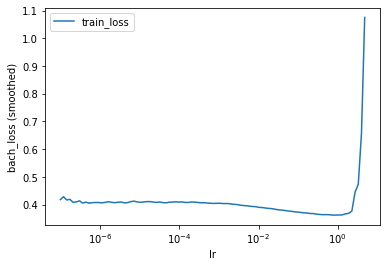

In [14]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [15]:
best = lrfinder.get_best_lr()

In [16]:
best

0.07390722033525823

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [17]:
model.optimizer.set_lr(best)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [18]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [19]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 0.4406,	val_loss: 0.2853
1:	[0s / 0s],		train_loss: 0.3518,	val_loss: 0.2908
2:	[0s / 0s],		train_loss: 0.3340,	val_loss: 0.2906
3:	[0s / 0s],		train_loss: 0.3193,	val_loss: 0.2696
4:	[0s / 0s],		train_loss: 0.3181,	val_loss: 0.2705
5:	[0s / 0s],		train_loss: 0.3052,	val_loss: 0.2997
6:	[0s / 0s],		train_loss: 0.3110,	val_loss: 0.2706
7:	[0s / 0s],		train_loss: 0.3119,	val_loss: 0.2649
8:	[0s / 0s],		train_loss: 0.3069,	val_loss: 0.2834
9:	[0s / 0s],		train_loss: 0.3034,	val_loss: 0.2796
10:	[0s / 0s],		train_loss: 0.2994,	val_loss: 0.2713
11:	[0s / 0s],		train_loss: 0.3031,	val_loss: 0.2743
12:	[0s / 0s],		train_loss: 0.2994,	val_loss: 0.2847
13:	[0s / 0s],		train_loss: 0.2957,	val_loss: 0.2761
14:	[0s / 0s],		train_loss: 0.2986,	val_loss: 0.2775
15:	[0s / 0s],		train_loss: 0.3011,	val_loss: 0.2807
16:	[0s / 0s],		train_loss: 0.3007,	val_loss: 0.2837
17:	[0s / 0s],		train_loss: 0.2901,	val_loss: 0.2690
Wall time: 966 ms


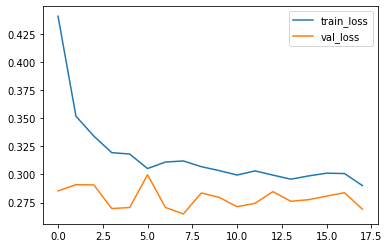

In [20]:
_ = log.plot()

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

#### Evaluation for DSAFT model

To exploit evaluation metrics provided by PyCox, survival function on durations (especially from training dataset) must be estimated. For this, Kaplan-Meier estimator is used, and estimated residuals are used as duration dataset.

In [21]:
def get_surv(model, x_test, timegrid = "train"):
    '''
    model: PyCox model class or compatibles
    x_test: covariate dataset to compute survival estimates
    '''
    from lifelines import NelsonAalenFitter
    import numpy as np
    import pandas as pd
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    x_train, target = model.training_data
    y_train, delta_train = target
    
    # compute residual from training data
    exp_residual = np.exp(np.log(y_train) - model.predict(x_train).reshape(-1))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict = np.exp(-model.predict(x_test)).reshape(-1)
    
    # estimate cumulative baseline hazard function
    # based on training dataset
    H = NelsonAalenFitter().fit(exp_residual, event_observed = delta_train).cumulative_hazard_
    
    # extract timegrid and estimated hazards
    time_grid = H.index.to_numpy()[1:]
    H_base = H.values.reshape(-1)
    
    h_base = H_base[1:] - H_base[:-1]
    h_base = np.repeat(h_base.reshape(-1, 1), exp_predict.shape[0], axis = 1)
    
    # evaluate conditional cumulative hazard estimates
    # based on test dataset
    surv = pd.DataFrame(np.exp(-np.cumsum(h_base * exp_predict, axis = 0)),
                        index = time_grid, columns = [i for i in range(exp_predict.shape[0])])
    surv.index.names = ["duration"]
    
    # set upperbound of time grid to "Y" of training dataset
    # (to be comparable to survival predictions from PyCox models)
    if timegrid == "train":
        surv = surv.loc[surv.index <= y_train.max()]
    
    return surv

In [22]:
surv = get_surv(model, x_test)

In [23]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [24]:
ev.concordance_td()

0.6660450923885405

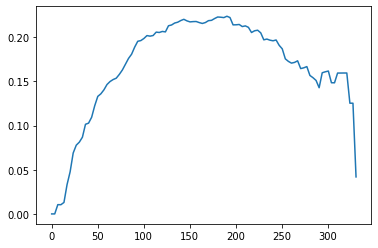

In [25]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [26]:
ev.integrated_brier_score(time_grid)

0.1681727294097344

In [27]:
ev.integrated_nbll(time_grid)

0.5009323549407673